# Setup

In [2]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [3]:
data = np.load('/content/drive/MyDrive/airfoil_interp.npy')
print(data.shape)
print(data[np.isnan(data)])

(1528, 192, 2)
[]


In [4]:
LATENT_DIM = 5 # R span
NOISE_DIM = 10
BEZIER_DIM = 32
SAMPLE_PARAMETER_DIM = 10
POINT_DIM = data.shape[1]

EPOCH = 100
BATCH = 32
LR = 5E-4 # modify
EPSILON = 0.3

# loss
LAMBDAI = 1
LAMBDA1 = 1
LAMBDA2 = 1
LAMBDA3 = 1
LAMBDA4 = 1

train_loader = DataLoader(data[:-200], batch_size = BATCH, shuffle = True)
val_loader = DataLoader(data[-200:-100], batch_size = BATCH, shuffle = True)
test_loader = DataLoader(data[-100:], batch_size = BATCH, shuffle = True)

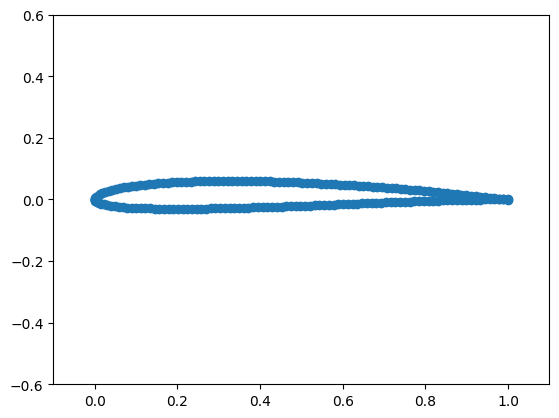

In [5]:
idx = 100
plt.scatter(data[idx, :, 0], data[idx, :, 1])
plt.xlim(-0.1, 1.1)
plt.ylim(-0.6, 0.6)
plt.show()

# Model

In [6]:
n = BEZIER_DIM + 1
with torch.no_grad():
  C = torch.Tensor([math.comb(n-1, i) for i in range(n)]).unsqueeze(0).unsqueeze(0).repeat(BATCH, POINT_DIM, 1)
  I = torch.Tensor([i for i in range(n)]).unsqueeze(0).unsqueeze(0).repeat(BATCH, POINT_DIM, 1)
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()

    self.deconv_depth = 32
    self.deconv_dim = int(BEZIER_DIM/8)
    self.kernel = (4, 3)

    self.H1 = nn.Linear(LATENT_DIM + NOISE_DIM, 1024)
    self.bn1 = nn.BatchNorm1d(1024)
    self.H2 = nn.Linear(1024, self.deconv_dim * self.deconv_depth * 3)
    self.bn2 = nn.BatchNorm1d(self.deconv_dim * self.deconv_depth * 3)

    self.conv1 = nn.ConvTranspose2d(3, 16, self.kernel, stride=(2, 1), padding=(1, 1))
    self.bn3 = nn.BatchNorm2d(16)
    self.conv2 = nn.ConvTranspose2d(16, 32, self.kernel, stride=(2, 1), padding=(1, 1))
    self.bn4 = nn.BatchNorm2d(32)
    self.conv3 = nn.ConvTranspose2d(32, 64, self.kernel, stride=(2, 1), padding=(1, 1))
    self.bn5 = nn.BatchNorm2d(64)


    self.conv1_ = nn.ConvTranspose2d(3, 16, self.kernel, stride=(2, 1), padding=(1, 1))
    self.bn3_ = nn.BatchNorm2d(16)
    self.conv2_ = nn.ConvTranspose2d(16, 32, self.kernel, stride=(2, 1), padding=(1, 1))
    self.bn4_ = nn.BatchNorm2d(32)
    self.conv3_ = nn.ConvTranspose2d(32, 64, self.kernel, stride=(2, 1), padding=(1, 1))
    self.bn5_ = nn.BatchNorm2d(64)

    self.P = nn.Conv2d(64, 1, (1, 32))
    self.P_ = nn.Conv2d(64, 1, (1, 32))
    self.bnp = nn.BatchNorm1d(BEZIER_DIM)
    self.W = nn.Conv2d(64, 1, (1, 32))

    self.S1 = nn.Linear(LATENT_DIM + NOISE_DIM, 1024)
    self.Sbn1 = nn.BatchNorm1d(1024)
    self.S2 = nn.Linear(1024, 256)
    self.Sbn2 = nn.BatchNorm1d(256)
    self.S3_a = nn.Linear(256, SAMPLE_PARAMETER_DIM)
    self.S3_b = nn.Linear(256, SAMPLE_PARAMETER_DIM)
    self.S3_c = nn.Linear(256, SAMPLE_PARAMETER_DIM)

  def forward(self, c, z):

    cz = torch.cat([c, z], dim=1)

    x = F.leaky_relu(self.bn1(self.H1(cz)), 0.2)
    x = F.leaky_relu(self.bn2(self.H2(x)), 0.2)
    x = x.view(-1, 3, self.deconv_dim, self.deconv_depth)

    p = F.leaky_relu(self.bn3(self.conv1(x)), 0.2)
    p = F.leaky_relu(self.bn4(self.conv2(p)), 0.2)
    p = F.tanh(self.bn5(self.conv3(p)))


    p_ = F.leaky_relu(self.bn3_(self.conv1_(x)), 0.2)
    p_ = F.leaky_relu(self.bn4_(self.conv2_(p_)), 0.2)
    p_ = F.tanh(self.bn5_(self.conv3_(p_)))

    w = 0.75 + 0.5 * torch.sigmoid(self.W(p))
    w = w.squeeze(dim=1)

    p = self.P(p)
    p_ = self.P_(p_)
    p = torch.cat([p, p_], dim=2)
    p = 1.5 * F.tanh(0.5 * self.bnp(p.view(BATCH, BEZIER_DIM, 2)))


    s = F.leaky_relu(self.Sbn1(self.S1(cz)), 0.2)
    s = F.leaky_relu(self.Sbn2(self.S2(s)), 0.2)
    a = 2 * torch.sigmoid(self.S3_a(s)) * (1-EPSILON) + EPSILON
    b = 2 * torch.sigmoid(self.S3_b(s)) * (1-EPSILON) + EPSILON
    c = F.softmax(self.S3_c(s), dim=1)

    a = a.unsqueeze(1).repeat(1, POINT_DIM, 1)
    b = b.unsqueeze(1).repeat(1, POINT_DIM, 1)
    c = c.unsqueeze(1).repeat(1, POINT_DIM, 1)

    u = torch.linspace(0, 1, steps=POINT_DIM + 2)[1:-1].unsqueeze(0).unsqueeze(2).repeat(BATCH, 1, SAMPLE_PARAMETER_DIM)
    u_ = (c * ( 1 - ( 1 - u ** a ) ** b )).sum(dim=2)
    # u_ = torch.linspace(0, 1, steps=POINT_DIM + 2)[1:-1].unsqueeze(0).repeat(BATCH, 1)
    # print(u_.isnan().numpy().sum())

    addition = torch.zeros_like(p)
    addition[:, :, 0] += 0.5
    p = p + addition # data 반영
    P = (torch.cat([p, p[:, 0, :].unsqueeze(1)], dim=1)).unsqueeze(1).repeat(1, POINT_DIM, 1, 1)
    W = (torch.cat([w, w[:, 0, :].unsqueeze(1)], dim=1)).unsqueeze(1).repeat(1, POINT_DIM, 1, 2)
    U = u_.unsqueeze(2).repeat(1, 1, n)
    # print(U.shape, I.shape, C.shape)
    N = (C * (U ** I) * ((1-U) ** (n-1 - I))).unsqueeze(3).repeat(1, 1, 1, 2)
    # print(C.shape)
    B = (P * W * N).sum(dim=2) / (N * W).sum(dim=2)
    return p, w, a, b, c, B

In [7]:
G = Generator()
P, _, _, _, _, B = G(torch.rand((BATCH, LATENT_DIM)), torch.rand((BATCH, NOISE_DIM)))
# B = B[0].detach().numpy()

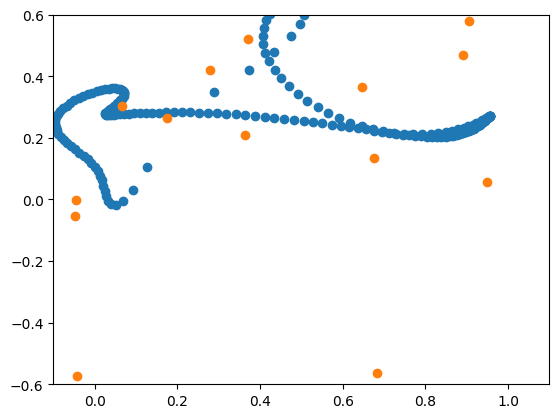

In [8]:
plt.scatter(B[0].detach().numpy()[:, 0], B[0].detach().numpy()[:, 1])
plt.scatter(P[0].detach().numpy()[:, 0], P[0].detach().numpy()[:, 1])
plt.xlim(-0.1, 1.1)
plt.ylim(-0.6, 0.6)
plt.show()

In [9]:
class Discriminator(nn.Module):

  def __init__(self):
    super(Discriminator, self).__init__()

    self.kernel = (4, 2)
    self.dropout = nn.Dropout(0.4)

    # (batch, point, 2)
    self.conv1 = nn.Conv2d(1, 4, self.kernel, stride=(2, 1), padding=(1, 1))
    self.bn1 = nn.BatchNorm2d(4)
    self.conv2 = nn.Conv2d(4, 8, self.kernel, stride=(2, 1), padding=(1, 1))
    self.bn2 = nn.BatchNorm2d(8)
    self.conv3 = nn.Conv2d(8, 16, self.kernel, stride=(2, 1), padding=(1, 1))
    self.bn3 = nn.BatchNorm2d(16)
    self.conv4 = nn.Conv2d(16, 32, self.kernel, stride=(2, 1), padding=(1, 1))
    self.bn4 = nn.BatchNorm2d(32)
    self.conv5 = nn.Conv2d(32, 64, self.kernel, stride=(2, 1), padding=(1, 1))
    self.bn5 = nn.BatchNorm2d(64)

    self.H1 = nn.Linear(2688, 1024)
    self.bn6 = nn.BatchNorm1d(1024)

  def forward(self, b):
    b = b.unsqueeze(1)
    b = F.leaky_relu(self.bn1(self.conv1(b)), 0.2)
    b = self.dropout(b)
    b = F.leaky_relu(self.bn2(self.conv2(b)), 0.2)
    b = self.dropout(b)
    b = F.leaky_relu(self.bn3(self.conv3(b)), 0.2)
    b = self.dropout(b)
    b = F.leaky_relu(self.bn4(self.conv4(b)), 0.2)
    b = self.dropout(b)
    b = F.leaky_relu(self.bn5(self.conv5(b)), 0.2)
    b = self.dropout(b)

    b = torch.flatten(b, 1)
    b = F.leaky_relu(self.bn6(self.H1(b)), 0.2)
    b = self.dropout(b)

    return b

In [10]:
class DHead(nn.Module):
  def __init__(self):
    super().__init__()
    self.D1 = nn.Linear(1024, 1)
  def forward(self, b):
    d = torch.sigmoid(self.D1(b))
    return d

class QHead(nn.Module):
  def __init__(self):
    super().__init__()
    self.Q1 = nn.Linear(1024, 128)
    self.bn7 = nn.BatchNorm1d(128)
    self.Q2 = nn.Linear(128, LATENT_DIM)
    self.Q2_std = nn.Linear(128, LATENT_DIM)
  def forward(self, b):
    q = F.leaky_relu(self.bn7(self.Q1(b)), 0.2)
    q_mean = self.Q2(q)
    q_std = torch.exp(self.Q2_std(q))
    return q_mean, q_std

In [11]:
D = Discriminator()
DH = DHead()
QH = QHead()
DH(D(B)), DH(D(B))


(tensor([[0.4233],
         [0.6939],
         [0.5490],
         [0.3537],
         [0.5953],
         [0.4641],
         [0.4372],
         [0.6702],
         [0.5326],
         [0.4839],
         [0.5021],
         [0.5997],
         [0.3810],
         [0.4252],
         [0.5139],
         [0.4991],
         [0.4814],
         [0.6268],
         [0.5145],
         [0.4143],
         [0.4107],
         [0.6986],
         [0.4767],
         [0.5999],
         [0.5312],
         [0.5955],
         [0.2643],
         [0.6374],
         [0.5341],
         [0.3003],
         [0.6916],
         [0.5723]], grad_fn=<SigmoidBackward0>),
 tensor([[0.4107],
         [0.4936],
         [0.4039],
         [0.3166],
         [0.4823],
         [0.4017],
         [0.6431],
         [0.5918],
         [0.3185],
         [0.5559],
         [0.5333],
         [0.3858],
         [0.4822],
         [0.6911],
         [0.7001],
         [0.4989],
         [0.4201],
         [0.3906],
         [0.6520],
 

# Training

In [12]:
device = torch.device('cpu')

D.to(device)
G.to(device)
DH.to(device)
QH.to(device)

d_optim = torch.optim.Adam([{'params': D.parameters()}, {'params': DH.parameters()}], lr = LR)
g_optim = torch.optim.Adam([{'params': G.parameters()}, {'params': QH.parameters()}], lr = LR)

In [13]:
class GaussianNLLoss(nn.Module):
  def __init__(self):
    super().__init__()
  def forward(self, c, q, std):
    l = torch.log(std) + ((c-q)**2 / (2 * std ** 2))
    l = l.mean()
    return l

class BLoss(nn.Module):
  def __init__(self):
    super().__init__()
  def forward(self, p, w, a, b, l1, l2, l3, l4):
    p_shift = (torch.cat([p, p[:, 0, :].unsqueeze(1)], dim=1))[:, :-1, :]
    p_dist = torch.abs(p - p_shift).sum(2)
    param_dist = torch.abs((a - 1)).mean() + torch.abs((b - 1)).mean()
    lf = l1 * p_dist.mean() + l2 * p_dist.max(1)[0].mean(0) + l3 * torch.abs(w).mean() + l4 * param_dist
    return lf

torch.autograd.set_detect_anomaly(True)
GNLL = GaussianNLLoss()
BL = BLoss()
criterion = nn.BCELoss()

Epoch 1/100


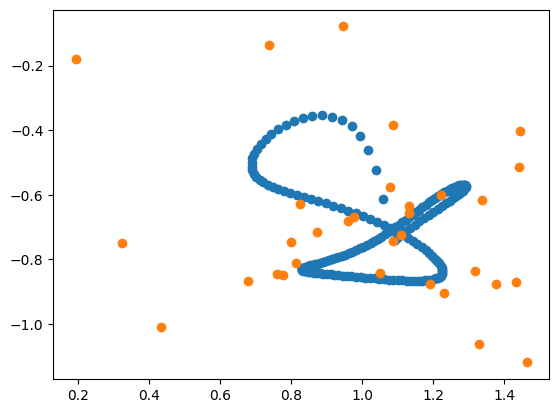

G ; 103.45097351074219, D ; 61.131736755371094
Epoch 2/100


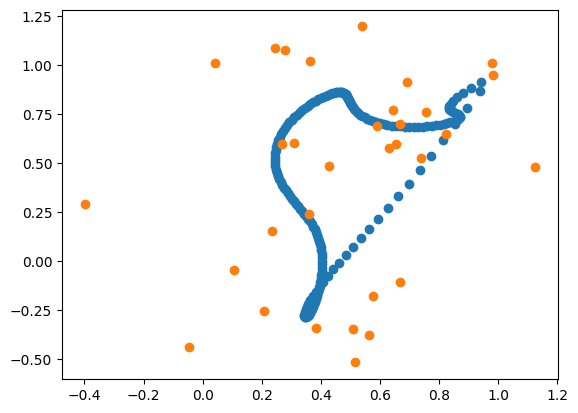

G ; 90.4433364868164, D ; 59.6579475402832
Epoch 3/100


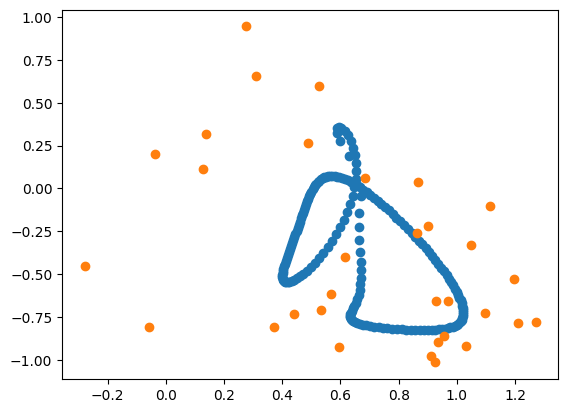

G ; 82.95011901855469, D ; 59.51546859741211
Epoch 4/100


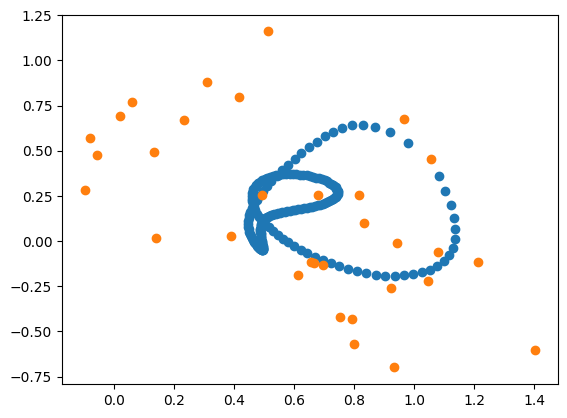

G ; 77.8512954711914, D ; 59.317596435546875
Epoch 5/100


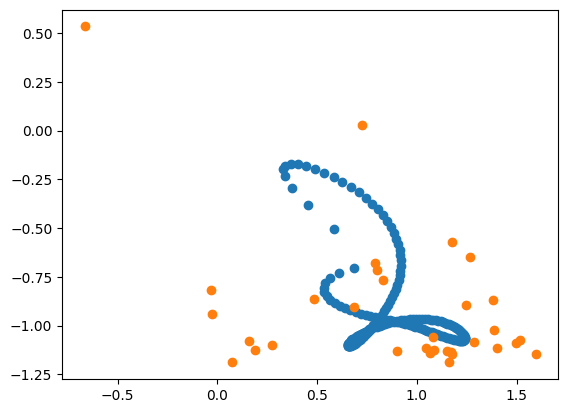

G ; 72.54673767089844, D ; 58.59174346923828
Epoch 6/100


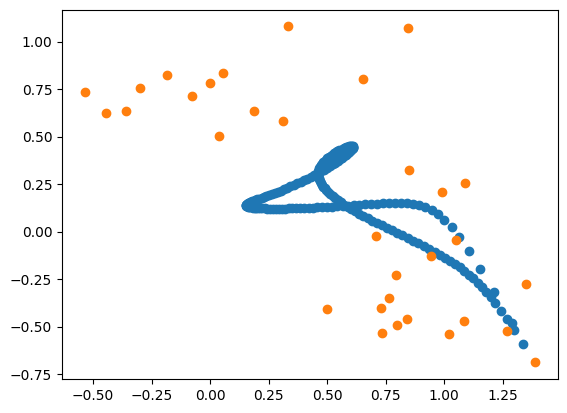

G ; 69.64496612548828, D ; 58.66304016113281
Epoch 7/100


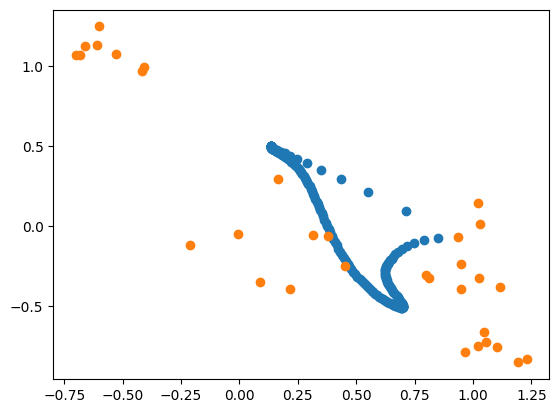

G ; 67.78197479248047, D ; 58.57432174682617
Epoch 8/100


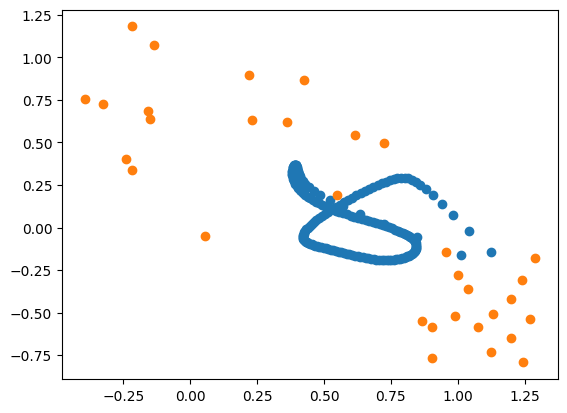

G ; 64.76936340332031, D ; 58.489356994628906
Epoch 9/100


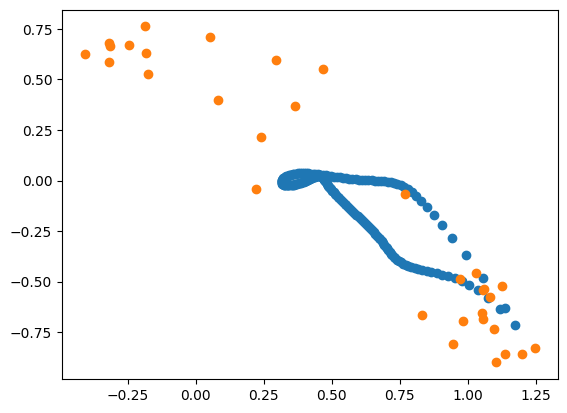

G ; 63.592628479003906, D ; 58.35470199584961
Epoch 10/100


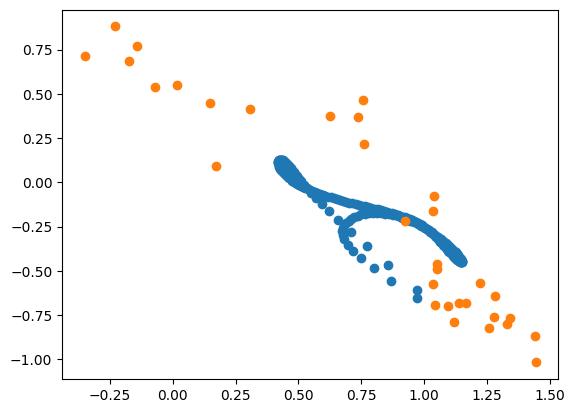

G ; 62.15931701660156, D ; 58.26873779296875
Epoch 11/100


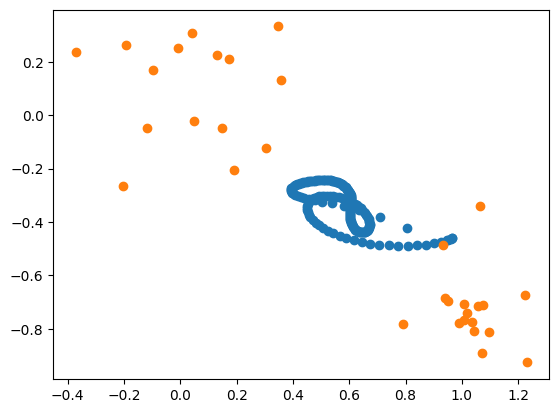

G ; 60.66362762451172, D ; 58.17384719848633
Epoch 12/100


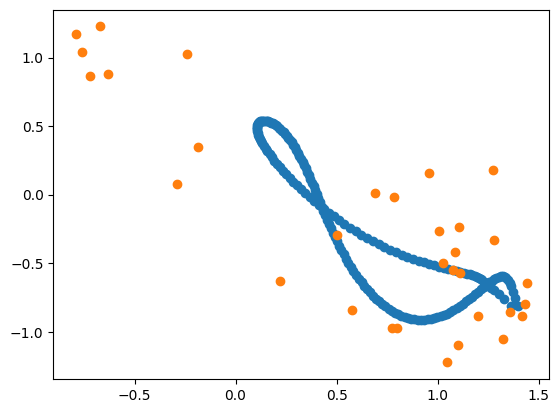

G ; 60.135562896728516, D ; 57.87366485595703
Epoch 13/100


In [ ]:

for epoch in range(EPOCH):
  print(f"Epoch {epoch+1}/{EPOCH}")
  g_loss_table = 0
  d_loss_table = 0
  for i, data in enumerate(train_loader):
    if True:
      # d_optim
      d_optim.zero_grad()
      # real
      b_r = data.to(torch.float)
      d_r = D(b_r)
      p_r = DH(d_r)
      ones_r = torch.ones_like(p_r)
      l_r = criterion(p_r, ones_r)
      l_r.backward()
      # fake
      noise = torch.randn(BATCH, NOISE_DIM) # gaussian noise(0, 1)
      latent = torch.randn(BATCH, LATENT_DIM)
      _, _, _, _, _, b = G(latent, noise)
      d_f = D(b.detach())
      p_f = DH(d_f)
      zeros = torch.zeros(BATCH, 1)
      l_f = criterion(p_f, zeros)
      l_f.backward()

      d_loss_table += l_r + l_f
      d_optim.step()


    # g_optim
    g_optim.zero_grad()
    # fake
    noise = torch.randn(BATCH, NOISE_DIM) # gaussian noise(0, 1)
    latent = torch.randn(BATCH, LATENT_DIM)
    P, W, A, B, _, b = G(latent, noise)
    g_d_f = D(b)
    g_p_f = DH(g_d_f)
    ones = torch.ones(BATCH, 1)
    g_l_f = criterion(g_p_f, ones)

    q_mean, q_std = QH(g_d_f)
    g_latentL_f = LAMBDAI * GNLL(latent, q_mean, q_std) + BL(P, W, A, B, LAMBDA1, LAMBDA2, LAMBDA3, LAMBDA4)

    g_l = g_l_f + g_latentL_f
    g_l.backward()
    g_optim.step()

    g_loss_table += g_l
  with torch.no_grad():
    P, _, _, _, _, B = G(latent, noise)
    plt.scatter(B[0].detach().numpy()[:, 0], B[0].detach().numpy()[:, 1])
    plt.scatter(P[0].detach().numpy()[:, 0], P[0].detach().numpy()[:, 1])
    plt.show()
  print(f"G ; {g_loss_table}, D ; {d_loss_table}")

In [ ]:
PATH = '/content/drive/MyDrive/RL/BEZ/'
torch.save(D, PATH + 'D')
torch.save(DH, PATH + 'DH')
torch.save(QH, PATH + 'QH')
torch.save(G, PATH + 'G')

In [ ]:

for epoch in range(EPOCH):
  print(f"Epoch {epoch+1}/{EPOCH}")
  g_loss_table = 0
  d_loss_table = 0
  for i, data in enumerate(train_loader):
    if True:
      # d_optim
      d_optim.zero_grad()
      # real
      b_r = data.to(torch.float)
      d_r = D(b_r)
      p_r = DH(d_r)
      ones_r = torch.ones_like(p_r)
      l_r = criterion(p_r, ones_r)
      l_r.backward()
      # fake
      noise = torch.randn(BATCH, NOISE_DIM) # gaussian noise(0, 1)
      latent = torch.randn(BATCH, LATENT_DIM)
      _, _, _, _, _, b = G(latent, noise)
      d_f = D(b.detach())
      p_f = DH(d_f)
      zeros = torch.zeros(BATCH, 1)
      l_f = criterion(p_f, zeros)
      l_f.backward()

      d_loss_table += l_r + l_f
      d_optim.step()


    # g_optim
    g_optim.zero_grad()
    # fake
    noise = torch.randn(BATCH, NOISE_DIM) # gaussian noise(0, 1)
    latent = torch.randn(BATCH, LATENT_DIM)
    P, W, A, B, _, b = G(latent, noise)
    g_d_f = D(b)
    g_p_f = DH(g_d_f)
    ones = torch.ones(BATCH, 1)
    g_l_f = criterion(g_p_f, ones)

    q_mean, q_std = QH(g_d_f)
    g_latentL_f = LAMBDAI * GNLL(latent, q_mean, q_std) + BL(P, W, A, B, LAMBDA1, LAMBDA2, LAMBDA3, LAMBDA4)

    g_l = g_l_f + g_latentL_f
    g_l.backward()
    g_optim.step()

    g_loss_table += g_l
  with torch.no_grad():
    P, _, _, _, _, B = G(latent, noise)
    plt.scatter(B[0].detach().numpy()[:, 0], B[0].detach().numpy()[:, 1])
    plt.scatter(P[0].detach().numpy()[:, 0], P[0].detach().numpy()[:, 1])
    plt.show()
  print(f"G ; {g_loss_table}, D ; {d_loss_table}")